In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')
sns.set(font_scale=2.5)

In [3]:
!pip install plotly

In [4]:
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

In [7]:
df_train = pd.read_csv('train.csv')
df_test =pd.read_csv('test.csv')

In [8]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [9]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
# df_test의 Fare에서 null인 값에 Fare열의 평균 입력

In [10]:
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## 3. Feature engineering

In [11]:
# dataset에 의존하는 null data를 채운다.
# null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내 채움
# null data를 어떻게 채우냐에 따라 모델의 성능 결정 (신경 써야함)
# Feature engineering은 실제 모델의 학습에 쓰임 train과 test에 둘다 적용

### 3.1 Fill Null

#### 3.1.1 Fill Null in Age using title

In [12]:
# title + statistics 사용 null data 채우기
# str method : string으로 변환, extract method : 정규표현식 적용
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [13]:
# initial과 sex간의 count
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap = 'summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [14]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [15]:
df_train.groupby('Initial').mean()
# 여성과 관계있는 Miss, Mr, Mrs가 생존률이 높은 것을 볼 수 있다.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


<AxesSubplot:xlabel='Initial'>

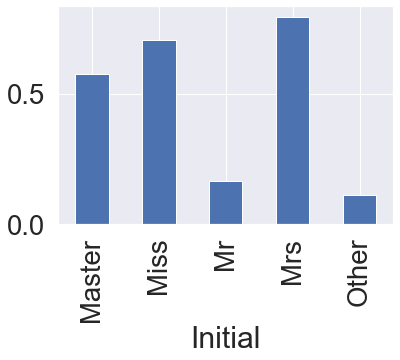

In [16]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [17]:
# statistic = train data
# train data에서 얻은 statistic을 기반으로 test의 null data를 채워야 한다.
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [18]:
# Age의 평균을 이용 Null value 채우기
# pandas dataframe -> boolean array이용 indexing

In [19]:
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Mr'), 'Age'] = 33
# Age가 isnull() 이면서 initial이 Mr 이면 'Age' 의 값 33으로 치환
# loc + boolean + column 이용 값 치환
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

#### 3.1.2 Fill Null in Embarked

In [20]:
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null values')
# Embarked 의 null 데이터는 두개이고 탑승색은 S에서 가장 많았으므로 S로 대체

Embarked has 2 Null values


In [21]:
df_train['Embarked'].fillna('S', inplace = True)

### 3.2 Change Age(continuous to categorical)

In [22]:
# Age 변수의 continuous를 categorical화한다.

In [23]:
# 1. dataframe의 indexing 방법인 loc를 사용하여 직접 변환
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(df_train['Age'] >= 10) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(df_train['Age'] >= 20) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(df_train['Age'] >= 30) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(df_train['Age'] >= 40) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(df_train['Age'] >= 50) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(df_train['Age'] >= 60) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[(df_train['Age'] >= 70), 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [24]:
# 2.함수를 만들어 apply 메소드 사용
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [25]:
# 위의 두 방법은 과정은 다르지만 결과는 같아야한다.
# all 메소드 사용 / 모든 값이 같으면 True 하나라도 False면 False
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> True


In [26]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace = True)
# 중복되는 컬럼 제거

### 3.3 Change Initial, Embarked and Sex ( string to numerical)

In [27]:
# Initial처럼 카테고리로 표현된 데이터는 모델이 인풋 시 수치화 시킨다.
# map method 활용 수치화

In [28]:
# Initial 수치화
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

In [29]:
# Embarked 수치화
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [30]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [31]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [32]:
df_train['Embarked'].isnull().any()

False

In [33]:
# Sex 수치화
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

In [34]:
# feature 간의 상관관계
# 두 변수간 Pearson correlation 을 구하면 (-1,1)사이의 값을 얻음
# 1은 양의 상관관계, -1은 음의 상관관계, 0은 상관관계가 없음
# 여러 개의 feature를 하나의 matrix형태로 표현 -> heatmap
# dataframe의 corr()메소드와 seaborn으로 표현

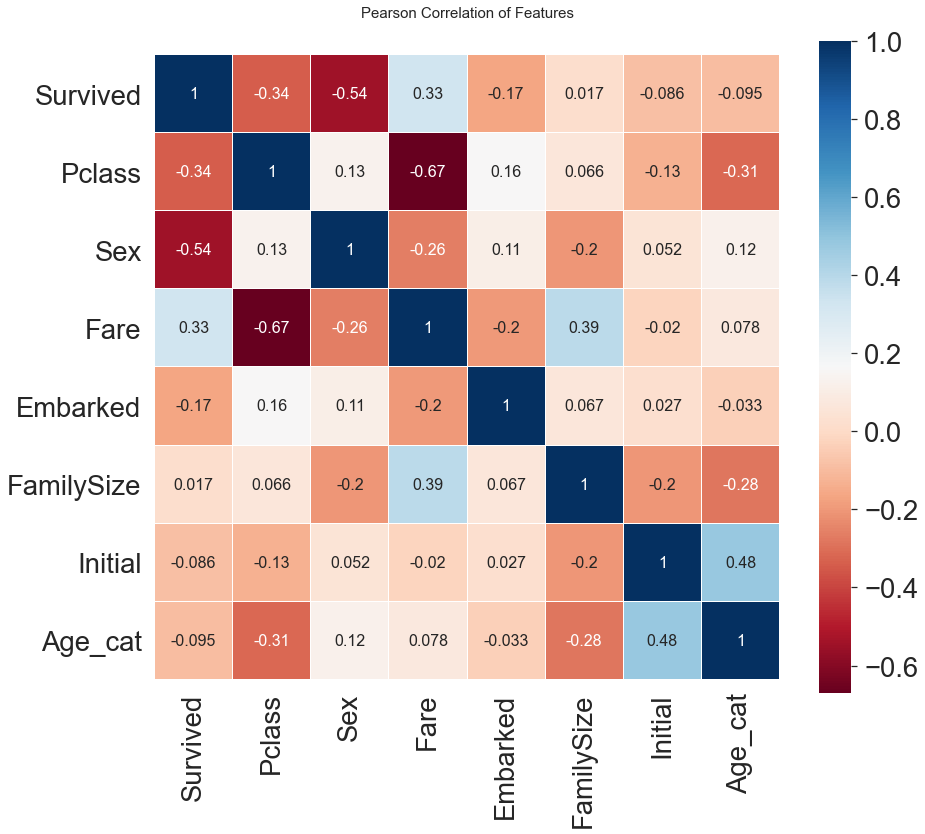

In [35]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor = 'white', annot=True, annot_kws={'size':16})

del heatmap_data
# 서로 강한 상관관계를 가지는 feature들이 없다
# = 모델을 학습시킬때 불필요한 feature가 없다

### 3.4 One-hot encoding on Initial and Embarked

In [36]:
# 모델의 성능을 높이기 위해, 수치화시킨 카테고리 데이터를 one-hot encoding 해줌
# one-hot encoding -> (0,1)로 이루어진 5차원의 벡터로 나타내는 것
# pandas의 get_dummies 사용

In [37]:
df_train = pd.get_dummies(df_train, columns = ['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [38]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [39]:
df_test.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,892,3,"Kelly, Mr. James",1,0,0,330911,2.057860,NaN,1,1,3,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,1,0,363272,1.945910,NaN,2,2,4,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",1,0,0,240276,2.270836,NaN,1,1,6,0,0,1,0,0
3,895,3,"Wirz, Mr. Albert",1,0,0,315154,2.159003,NaN,2,1,2,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,3101298,2.508582,NaN,2,3,2,0,0,0,1,0


In [40]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [41]:
df_train.head()
df_test.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,892,3,"Kelly, Mr. James",1,0,0,330911,2.057860,NaN,1,3,0,0,1,0,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,1,0,363272,1.945910,NaN,2,4,0,0,0,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",1,0,0,240276,2.270836,NaN,1,6,0,0,1,0,0,0,1,0
3,895,3,"Wirz, Mr. Albert",1,0,0,315154,2.159003,NaN,1,2,0,0,1,0,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,3101298,2.508582,NaN,3,2,0,0,0,1,0,0,0,1


### 3.5 Drop columns

In [42]:
#필요한 컬럼만 남기고 모두 지움
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [43]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [44]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


## 4 Building machine learning model and prediction using the trained model

In [45]:
!pip install sklearn
# 머신러닝의 처음부터 끝까지 존재

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #모델의 평가
from sklearn.model_selection import train_test_split #traning set를 쉽게 나눠줌

### 4.1 Preparation - Split dataset into train, valid, test set

In [47]:
# 학습에 쓰일 데이터와, target label(Survived)를 분리, drop 사용
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [48]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

### 4.2 Model generation and prediction

In [49]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [50]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))


총 268명 중 82.46% 정확도로 생존을 맞춤


### 4.3 Feature importance

In [51]:
# 학습된 모델은 feature importance를 가짐 : 결과값에 영향을 주는 정도
# pandas series 이용 sorting하여 그래프 그리기

In [52]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


In [53]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

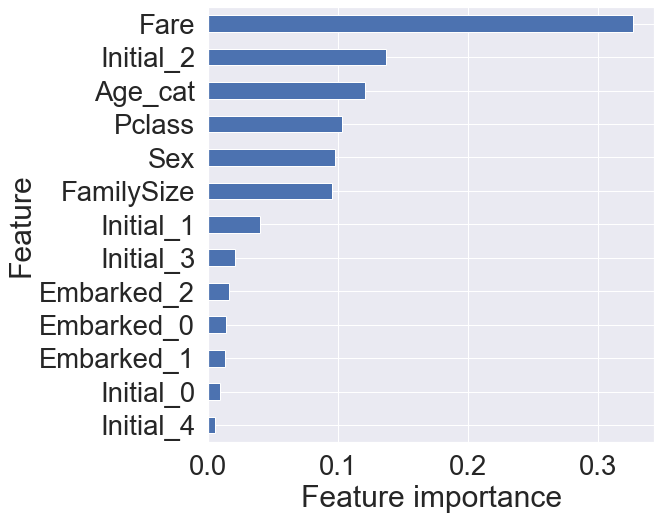

In [54]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

### 4.4 Prediction on Test set

In [ ]:
# 테스트셋을 모델에 주어 생존여부 예측,
# submission(제출용)이므로 결과는, leaderboard 에서 확인 가능

In [55]:
submission = pd.read_csv('gender_submission.csv')

In [56]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [57]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [58]:
submission.to_csv('./my_first_submission.csv', index=False)

## 5. Conclusion

In [60]:
result = pd.read_csv('my_first_submission.csv')

In [61]:
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
